In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis 학습 데이터 파악

In [22]:
import json
    # 손글씨 데이터에서 필요한 것들 (for GAN) 
    # text(클래스) : json_data['annotations'][idx]['text']
    # 성별, 연령대 : json_data['annotations'][idx]['attributes']  for pretraining - 잘 쓴 손글씨(여성)
    # 이미지 크기 : json_data['images'][idx]['width'] 또는 ['height']
    # 파일명 : json_data['images'][idx]['file_name']

In [23]:
metaFile_location = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/handwriting_data_info1.json'

with open(metaFile_location, 'r') as f:
    json_data = json.load(f)

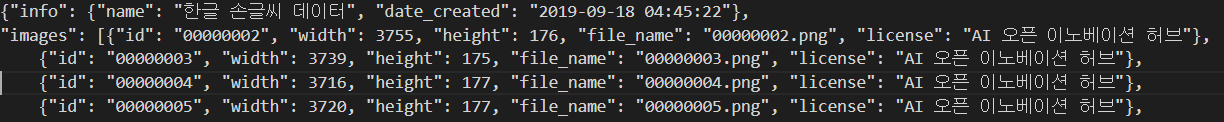

In [25]:
# 전체 이미지 수
print("전체 이미지 수 : ", len(json_data['images']) )
# 여기에는 문장 데이터, 단어 데이터, 음절 데이터 모두 포함됨

전체 이미지 수 :  1170622


In [46]:
ClassToFileNames, WordsToFileNames= {}, {}
syllableDataLength = 0

for idx, img_data in enumerate(json_data['images']):
    # idx 번째 이미지 데이터들에 대해 {클래스 : [파일명, 파일명, ...]}
    class_ = json_data['annotations'][idx]['text']
    fileName = json_data['images'][idx]['file_name']
    if len(class_) == 1:    
        # 한 글자인 경우만 ClassToFileNames에 넣기
        if class_ not in ClassToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
            ClassToFileNames[class_] = [] # 빈 리스트 생성
        ClassToFileNames[class_].append(fileName)
        syllableDataLength += 1
    else:
        # 단어, 문장의 경우 WordsToFileNames에 넣기
        if class_ not in WordsToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
            WordsToFileNames[class_] = [] # 빈 리스트 생성
        WordsToFileNames[class_].append(fileName)

# 한국어 글자 종류는 11,172가지.
print("음절 클래스 수 : ", len(ClassToFileNames) )
print("단어/문장 수 클래스 수: ", len(WordsToFileNames))

print("\n음절 데이터 수 : ", syllableDataLength)
print("단어/문장 데이터 수 : ", len(json_data['images']) - syllableDataLength)

print(f"\n한 음절 당 평균 {syllableDataLength/len(ClassToFileNames)} 개 손글씨 데이터 존재함")

음절 클래스 수 :  11172
단어/문장 수 클래스 수:  6054

음절 데이터 수 :  761109
단어/문장 데이터 수 :  409513

한 음절 당 평균 68.1264769065521 개 데이터 존재함


In [61]:
len(ClassToFileNames['가']) 
ClassToFileNames.keys()

dict_keys(['헳', '헴', '헵', '헶', '헷', '헸', '헹', '헺', '헻', '헼', '헽', '헾', '헿', '혀', '혂', '혃', '현', '혅', '혆', '혇', '혈', '혉', '혊', '혋', '혌', '혍', '혎', '혏', '혐', '협', '혒', '혓', '혔', '형', '혖', '혗', '혘', '혙', '혚', '혛', '혜', '혝', '혞', '혟', '혠', '혡', '혢', '혣', '혤', '혥', '혦', '혧', '혨', '혩', '혪', '혫', '혬', '혭', '혮', '혯', '혰', '혱', '혲', '혳', '혴', '혵', '혶', '혷', '호', '혹', '혺', '혻', '혼', '혽', '혾', '혿', '홀', '홁', '홂', '홃', '홄', '홅', '홆', '홇', '홈', '홉', '홊', '홋', '홌', '홍', '홎', '홏', '홐', '홑', '홒', '홓', '화', '확', '홖', '홗', '환', '홙', '홚', '홛', '활', '홝', '홞', '홟', '홠', '홡', '홢', '홣', '홤', '홥', '홦', '홧', '홨', '황', '홪', '홫', '홬', '홭', '홮', '홯', '홰', '홱', '홲', '홳', '홴', '홵', '홶', '홷', '홸', '홹', '홺', '홻', '홼', '홽', '홾', '홿', '횀', '횁', '횂', '횃', '횄', '횅', '횆', '횇', '횈', '횉', '횊', '횋', '회', '획', '횎', '횏', '횐', '횑', '횒', '횓', '횔', '횕', '횖', '횗', '횘', '횙', '횚', '횛', '횜', '횝', '횞', '횟', '결', '겱', '겲', '겳', '겴', '겵', '겶', '겷', '겸', '겹', '겺', '겻', '겼', '경', '겾', '겿', '곀', '곁', '곂', '곃', '계', '곅', '곆', '곇', '곈', '곉',

## GAN pretrain에 사용할 데이터(깔끔한 손글씨)

In [56]:
# zip 파일 읽기 
import zipfile
import io
from PIL import Image

location1 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/01_handwriting_syllable_images.zip'
location2 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/02_handwriting_syllable_images.zip'

my_zip1 = zipfile.ZipFile(location1)
my_zip2 = zipfile.ZipFile(location2)

In [59]:
print(len(my_zip1.namelist()))
print(len(my_zip2.namelist()))

# 위의 meta data에 따르면 761109여야 하는데 부족함.  왜지?? 
print('음절 데이터 수 : ', len(my_zip1.namelist()) + len(my_zip2.namelist()))

135842
593409
음절 데이터 수 :  729251


135842
593409
음절 데이터 수 :  729251


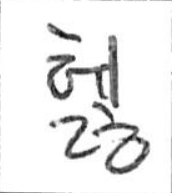

In [58]:
imageBinaryBytes = my_zip1.read(my_zip1.namelist()[1])
imageStream = io.BytesIO(imageBinaryBytes)
imageFile = Image.open(imageStream)
imageFile

In [65]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper

MY_GOOGLE_DRIVE_PATH = "/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"
!git pull

/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 4), reused 7 (delta 4), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/PILGI-Analog-To-Digital/Analog-PILGI-to-DIgital
   0cdca20..564acf2  main       -> origin/main
Updating 0cdca20..564acf2
Fast-forward
 README.md                  |   2 ++
 asset/11_16_IDEA_NOTE.docx | Bin 0 -> 297002 bytes
 2 files changed, 2 insertions(+)
 create mode 100644 asset/11_16_IDEA_NOTE.docx


In [66]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   "github_util.ipynb\341\204\213\341\205\264 \341\204\211\341\205\241\341\204\207\341\205\251\341\206\253.ipynb"

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	GAN.ipynb
	object_detection.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [67]:
!git add "GAN.ipynb"

In [68]:
!git commit -m"[ADD] EDA & fileRead"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@cd2cd8fd7850.(none)')
